Import necessary functions and libraries.

In [10]:
import numpy as np, cmath, scipy as sp
import scipy.io
from matplotlib import pyplot as plt

#import basic functions from numpy that we'll need
from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle, real, imag  
from numpy import zeros, ceil, floor, absolute
from numpy.fft import fft, ifft
from scipy import signal as sig
from scipy.signal import hilbert

%matplotlib inline

Import optional seaborn library for prettier plots.

In [2]:
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

###Figure 14.1

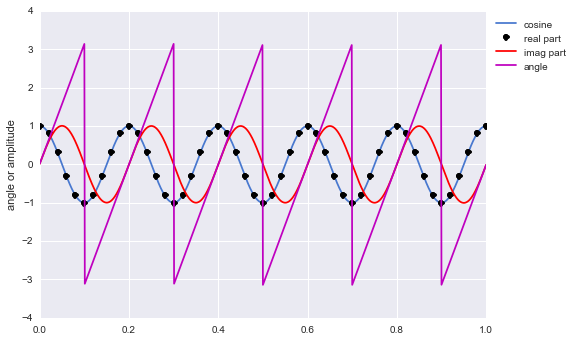

In [3]:
#create cosine
time = np.arange(0,1+0.001,0.001)
cosine = cos(2*pi*5*time)

#plot the signal, and the real & imaginary part of its hilbert transform, and the angle of the analytic signal
plt.plot(time,cosine)
plt.plot(time[::20],real(hilbert(cosine[::20])),'ko') #plot every 20th point bc of overlap
plt.plot(time,imag(hilbert(cosine)),'r')
plt.plot(time,angle(hilbert(cosine)),'m')

plt.ylabel("angle or amplitude")
_=plt.legend(['cosine','real part','imag part','angle'],bbox_to_anchor=[1.2,1])

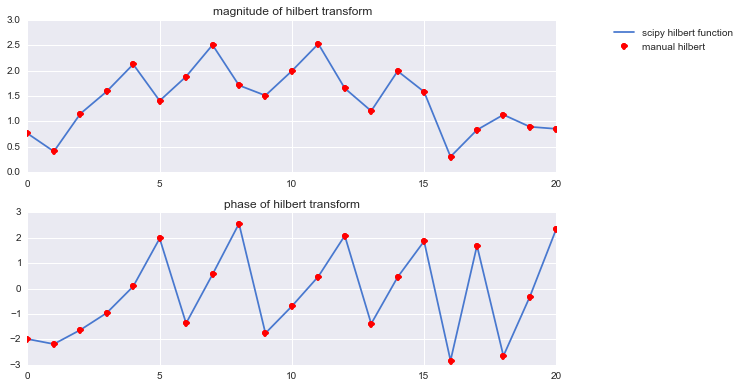

In [4]:
#The FFT-based hilbert transform

#generate random numbers
n = 21
randomnumbers = random.randn(21)

#take FFT
f = fft(randomnumbers)

#create copy that is multiplied by complex operator
complexf = 1j*f

#find indices of positive and negatice frequencies
posF = np.arange(1,floor(n/2.) + (n%2)).astype(int)
negF = np.arange(ceil(n/2.) + (~n%2),n).astype(int)

#rotate Fourier coefficients
#note1: this works by computing iAsin(2pft) component, i.e. phase quadrature
#note 2: positive frequencies are rotated counter clockwise, negative frequencies are rotated clockwise

f[posF] = f[posF] + -1j*complexf[posF]
f[negF] = f[negF] +  1j*complexf[negF]

#next two lines are alternative and slightly faster method
#book explains why this is equivalent
# f[posF] = f[posF] * 2
# f[negF] = f[negF] * 0

#take inverse FFT
hilbertx = ifft(f)

#compare with scipy's hilbert function
hilbertm = hilbert(randomnumbers)

#plot results

plt.subplot(211)
plt.plot(absolute(hilbertm))
plt.plot(absolute(hilbertx),'ro')
plt.legend(["scipy hilbert function","manual hilbert"],bbox_to_anchor = [1.35,1])
plt.title("magnitude of hilbert transform")

plt.subplot(212)
plt.plot(angle(hilbertm))
plt.plot(angle(hilbertx),'ro')
plt.title("phase of hilbert transform")

plt.tight_layout()

In [16]:
data = scipy.io.loadmat('sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]



EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

In [6]:
from firls import firls
#this is a Python firls() implementation taken from
#http://projects.scipy.org/scipy/attachment/ticket/648/designtools.py


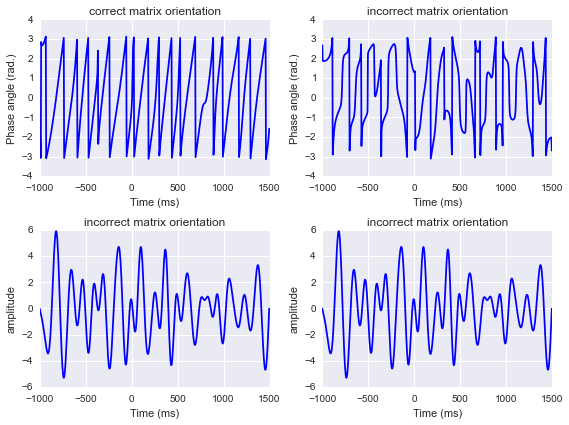

In [42]:
# first, filter data (filter mechanisms will be explained more below; for now, focus on 
# using the phases from the Hilbert transform to test whether the matrix input was correct)


nyquist = EEGsrate/2.
lower_filter_bound = 4. #hz
upper_filter_bound = 10. #hz

transition_width = 0.2
filter_order = np.round(3*EEGsrate/lower_filter_bound)

#create filter shape

ffrequencies = np.array([0, (1-transition_width) * lower_filter_bound, 
                        lower_filter_bound, upper_filter_bound, 
                         (1 + transition_width)* upper_filter_bound, nyquist]) / nyquist

idealresponse = np.array([0,0,1,1,0,0])
filterweights = firls(filter_order,ffrequencies,idealresponse) #use firls script described above

#apply the filter kernal to the data to obtain the band-pass filtered signal
filtered_data = zeros([EEGnbchan,EEGpnts]);

for chani in xrange(EEGnbchan):
    filtered_data[chani,:] = sig.filtfilt(filterweights,1,EEGdata[chani,:,0])

#  apply hilbert transform in correct and incorrect orientations
hilbert_oops = hilbert(filtered_data, axis=0);
hilbert_yes  = hilbert(filtered_data,axis=-1); #compute it along the last axis 

#  Note that the output of the hilbert transform is transposed to bring us back to an electrode X time matrix.
plt.figure(figsize=[8,6])

plt.subplot(221)
plt.plot(EEGtimes,angle(hilbert_yes[0,:]),'b');
plt.title('correct matrix orientation')
plt.xlabel('Time (ms)'), plt.ylabel('Phase angle (rad.)')
gca =plt.gca()
plt.setp(gca,'xlim',[-1000, 1500])

plt.subplot(222)
plt.plot(EEGtimes,angle(hilbert_oops[0,:]),'b');
plt.title('incorrect matrix orientation')
plt.xlabel('Time (ms)'), plt.ylabel('Phase angle (rad.)')
gca =plt.gca()
plt.setp(gca,'xlim',[-1000, 1500])

plt.subplot(223)
plt.plot(EEGtimes,real(hilbert_yes[0,:]),'b');
plt.title('incorrect matrix orientation')
plt.xlabel('Time (ms)'), plt.ylabel('amplitude')
gca =plt.gca()
plt.setp(gca,'xlim',[-1000, 1500])

plt.subplot(224)
plt.plot(EEGtimes,real(hilbert_oops[0,:]),'b');
plt.title('incorrect matrix orientation')
plt.xlabel('Time (ms)'), plt.ylabel('amplitude')
gca =plt.gca()
plt.setp(gca,'xlim',[-1000, 1500])

plt.tight_layout()

###Figure 14.3

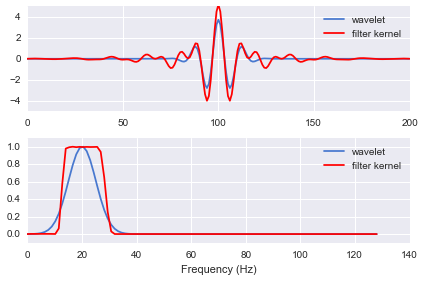

In [130]:
from scipy.stats.mstats import zscore

center_freq = 20 #in hz
filter_frequency_spread = 6 #Hz, +- center frequency
wavelet_frequency_spread = 4

#create wavelet
time = np.arange(-1000/EEGsrate/10.,1000/EEGsrate/10. + 1/EEGsrate,1/EEGsrate)

wavelet = exp(2*1j*pi*center_freq*time) * exp(-time**2/(2*(wavelet_frequency_spread/(2*pi*center_freq))**2))
wavelet = zscore(wavelet)

#compute its power spectrum
fft_wavelet = absolute(fft(wavelet))
fft_wavelet /= np.max(fft_wavelet) #normalized to one for visual comparison case

hz_wavelet = np.linspace(0,nyquist,len(time)/2. + 1) 

#construct filter kernel

transition_width = 0.2

ffrequencies   = np.array([ 0, (1-transition_width)*(center_freq-filter_frequency_spread),
                  (center_freq-filter_frequency_spread),
                  (center_freq+filter_frequency_spread),
                  (1+transition_width)*(center_freq+filter_frequency_spread),
                  nyquist ])/nyquist;


idealresponse = np.array([0,0,1,1,0,0])
filterweights = zscore(firls(200,ffrequencies,idealresponse))

#also compute weights using firwin
filterweights1=zscore(sig.firwin(201,np.array([center_freq-filter_frequency_spread,
                                  center_freq+filter_frequency_spread])/nyquist))

#compute its power spectrum
fft_filtkern = np.absolute(fft(filterweights))
fft_filtkern /=np.max(fft_filtkern) #again normalize to 1 for comparison

fft_filtkern1 = np.absolute(fft(filterweights1))[:-1]
fft_filtkern1 /=np.max(fft_filtkern1)

hz_filtkern = np.linspace(0,nyquist,101) #list of frequencies in hz corresponding to fitler kernel

#plot wavelet and filter kernel
plt.subplot(211)
plt.plot(real(wavelet))
plt.plot(filterweights,'r')
plt.legend(["wavelet","filter kernel"])
plt.setp(plt.gca(),'xlim',[0, 200],'ylim',[-5, 5])

#plot power spectra
plt.subplot(212)
plt.plot(hz_wavelet,fft_wavelet[:ceil(len(fft_wavelet)/2.)])
plt.plot(hz_filtkern,fft_filtkern[:ceil(len(fft_filtkern)/2.)],'r')
plt.legend(['wavelet','filter kernel'])
plt.setp(plt.gca(),'ylim',[-.1, 1.1])
plt.xlabel('Frequency (Hz)')

plt.tight_layout()
